# Data Analysis

# Clinic 2: Regress the price!

In this clinic you will use regression models to study house prices!

By completing and delivering the clinic tasks you will know how to :

* Use EDA to develop intuition and insights about which model is going to perform best
* Apply single and multiple regression models and interpret them in the context of specific applications 
* Apply cross-validation and regularization for delivering robust models

## Regression of real estate data
For this problem, you will analyze some real estate data. The dataset contains multiple listing service (MLS) real estate transactions for houses sold in 2015-16. We are primarily interested in regressing the `SoldPrice` on the house attributes (`property size`, `house size`, `number of bedrooms`, etc...).

Tasks 2.1-2.3 cover the EDA part on the data, therefore not graded. However, they are considered important part of the process. The goal is to work on these tasks either as a group or individually and share good advice with each other on how to proceed. In the process, we expect that you develop some intuition about the data and explanations 


### Task 2.1: Import the data (already done :))
Use the [`pandas.read_csv()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function to import the dataset (`houses.csv`). This pandas dataframe will be used for data exploration and linear regression. 

In [165]:
# imports and setup 
import pandas as pd
import scipy as sc
import numpy as np
import seaborn as sn
import statsmodels.formula.api as sm
import statsmodels
from sklearn.preprocessing import scale

#%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 

In [122]:
h = pd.read_csv('housespp.csv',index_col=0) #load data
print(h.shape)

(348, 21)


### Task 2.2: Clean the data 

1. There are 21 different variables associated with each of the 348 houses in this dataset. Skim them and try to get a rough understanding of what information this dataset contains. Here is an explanation of the variables.

'Access': status of the road to the property (asphalt, concrete etc.)<br>
'Acres': total area of the property in acres (acc. to Wikipedia "an acre may be declared as exactly 4,046.8564224<br> square metres")
'AirType': air-conditioning provider type (e.g. central, electric etc.)<br>
'Amenities': extra things available (e.g. cable tv, etc.) <br>
'DaysOnMkt': days that the property stayed on the market <br>
'Deck': how many floors <br>
'GaragCap': # of paring spots <br>
'Heat': heating type (e.g. electric, gas, etc.) <br>
'Latitude': location info (hint: we are in the USA but where?) <br>
'Longitude': location info (hint: we are in the USA but where?) <br>
'LstPrice': listed price <br>
'Patio': # of patios <br>
'PkgSpacs': # of parking spaces <br>
'PropType': property type (condo, single family, townhouse, ...) <br>
'Roof': type of roof (flat, asphalt, etc.) <br>
'SoldPrice': actual price that listing was sold <br>
'Taxes': taxes paid <br>
'TotBed': # of bedrooms <br>
'TotBth': # of bathrooms <br>
'TotSqf': area of the house in square feet <br>
'YearBlt': year built <br>

+ Only keep houses with List Price between 200,000 and 1,000,000 dollars. This is an arbitrary choice and we realize that some people are high rollers, but for our purposes we'll consider the others as outliers. 

+ As a minimal and required step, we are going to keep the following columns. However, for the last task (2.6) you are free to epxlore how other attributes affect the performance as well. But don't go crazy and avoid overfitting!

`['Acres', 'Deck', 'GaragCap', 'Latitude', 'Longitude', 'LstPrice', 'Patio', 'PkgSpacs', 'PropType', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']` 

+ Check the datatypes and convert any numbers that were read as strings to numerical values. (Hint: You can use [`str.replace()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.replace.html) to work with strings.) If there are any categorical values you're interested in, just make sure you include them as you find fit. In particular, convert 'TotSqf' to an integer and add a column titled `Prop_Type_num` that is 
$$
\text{Prop_Type_num}_i = \begin{cases} 
0 & \text{if $i$-th listing is a condo or townhouse} \\
1 & \text{if $i$-th listing is a single family house}
\end{cases}. 
$$
+ Remove the listings with erroneous `Longitude` (one has Longitude = 0) and `Taxes` values (two have unreasonably large values).

In [123]:
# your code goes here
def preprocess(h, columns):
    columns = ['Acres', 'Deck', 'GaragCap', 'Latitude', 'Longitude', 'LstPrice', 'Patio', 'PkgSpacs', 'PropType', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']
    def processCoordinate(x):
        try:
            x1,x2,x3 = [float(e) for e in x.split('.')]
            return x1 + (x2*1000 + x3)/1000000
        except:
            return np.NaN

    h = h[columns]
    h = h[(h['LstPrice'] >= 200000) & (h['LstPrice'] <= 1000000)]
    
    h['TotSqf'] = h['TotSqf'].str.replace(',', '').astype(int)
    dummies = pd.get_dummies(h['PropType'])
    h['Prop_Type_num'] = (dummies['Single Family'] == 1).astype(int)
        
    h['Longitude'] = h['Longitude'].apply(processCoordinate)
    h['Latitude'] = h['Latitude'].apply(processCoordinate)
    h = h.dropna()
    return h
    

In [124]:
h = preprocess(h)

In [125]:
h['Taxes'].sort_values(ascending=False)

ListNo
1384017    311262
1317390     99242
1351541      9205
1350311      8680
1306326      8025
            ...  
1348574       935
1330384       926
1368531       906
1369281       612
1322428         1
Name: Taxes, Length: 262, dtype: int64

In [129]:
h = h.drop(index = [1384017, 1317390])
h.shape

(260, 16)

In [132]:
h.head()

,Acres,Deck,GaragCap,Latitude,Longitude,LstPrice,Patio,PkgSpacs,PropType,SoldPrice,Taxes,TotBed,TotBth,TotSqf,YearBlt,Prop_Type_num
ListNo,,,,,,,,,,,,,,,,
1397571,0.29,1,3,40.779524,-110.106458,725000,1,0,Single Family,752000,7244,4.0,5.0,5415,1998,1
1394021,0.01,0,0,40.773243,-110.116709,205000,0,0,Condo,205000,1431,2.0,1.0,924,1965,0
1393604,0.11,0,0,40.773972,-110.132530,390000,1,0,Single Family,390000,1816,3.0,1.0,1702,1940,1
1393602,0.14,0,1,40.783009,-110.127900,445000,1,3,Single Family,443000,3260,3.0,2.0,1756,1940,1
1393370,0.01,0,2,40.771693,-110.113049,339000,0,2,Condo,334000,2141,3.0,2.0,1368,1976,0


In [131]:
h.dtypes

Acres            float64
Deck               int64
GaragCap           int64
Latitude         float64
Longitude        float64
LstPrice           int64
Patio              int64
PkgSpacs           int64
PropType          object
SoldPrice          int64
Taxes              int64
TotBed           float64
TotBth           float64
TotSqf             int64
YearBlt            int64
Prop_Type_num      int64
dtype: object

### Task 2.3: Exploratory data analywhereis 

1. Explore the dataset. Write a short description of the dataset describing the number of items, the number of variables and check to see if the values are reasonable. 

+ Make a bar chart showing the breakdown of the different types of houses (single family, townhouse, condo). 

+ Compute the correlation matrix and use a heat map to visualize the correlation coefficients. 
    - Use a diverging color scale from -1 to +1 (see `vmin` and `vmax` parameters for [pcolor](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.pcolor.html))
    - Show a legend
    - Make sure the proper labels are visible and readable (see [`xticks`](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.xticks.html) and the corresponding [`yticks`](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.yticks.html).

+ Make a scatter plot matrix to visualize the correlations. Color-code the dots by property type. For the plot, only use a subset of the columns: `['Acres', 'LstPrice', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']`. Determine which columns have strong correlations. 

+ Describe your findings with each other and share useful insights for the modeling part (to follow)


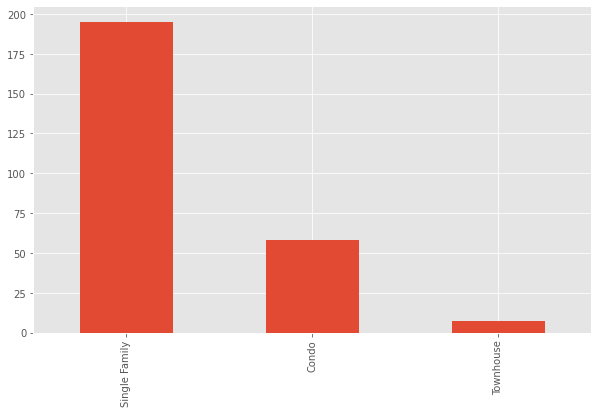

In [151]:
prop = h['PropType'].value_counts()
prop.plot.bar();

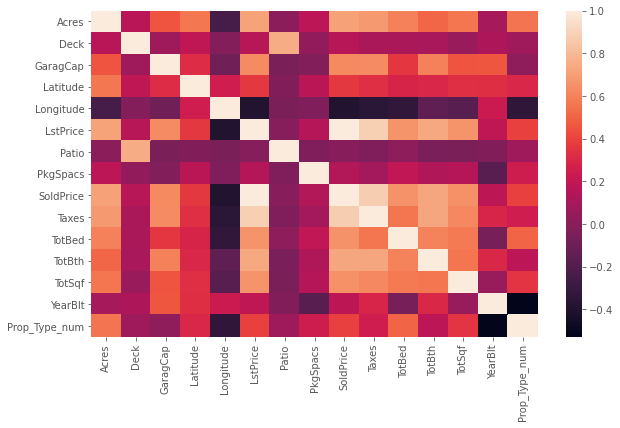

In [160]:
sn.heatmap(h.corr());

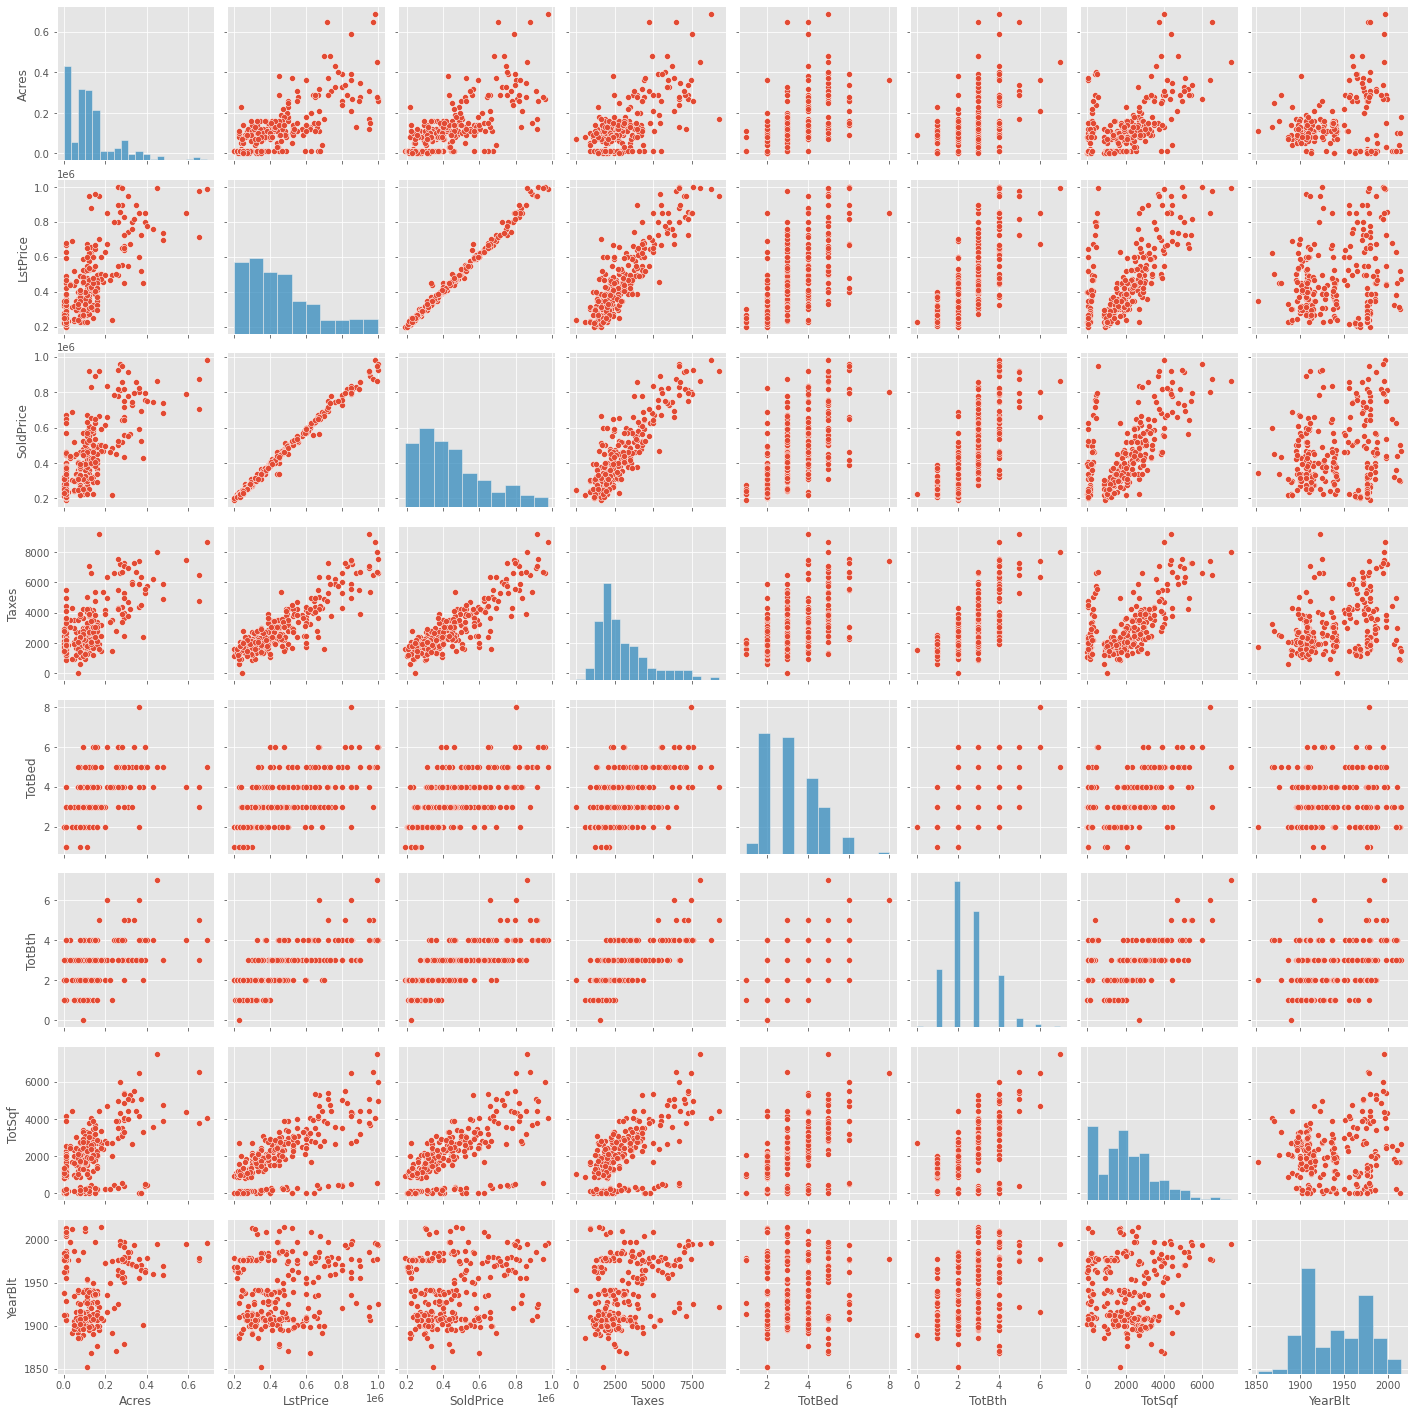

In [164]:
sn.pairplot(h[['Acres', 'LstPrice', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']]);

## DELIVERABLES (DEADLINE 5/March late night, wildcards possible)

Honor code applies from these tasks onwards (only individual work)

Instructions for the deliverable: 

* The tasks that are graded are 2.4-2.6. However, include your work in tasks 2.1-2.3. While, It is not graded, but it's important to include any preprocessing steps you have done, any decisions you made etc.

* Make sure that you include a proper amount/mix of comments, results and code.

* In the end, make sure that all cells are executed properly and everything you need to show is in your (execucted) notebook.

* You are asked to deliver **only your executed notebook file, .ipnyb** and nothing else. Enjoy!

### Task 2.4: Simple  Linear Regression 
Use the `ols` function from the [statsmodels](http://www.statsmodels.org/stable/index.html) package to regress the Sold price on some of the other variables (feel free to include all of them, however your work here should be based on the EDA you have done). Your model should be of the form:
$$
\text{Sold Price} = \beta_0 + \beta_1 x, 
$$
where $x$ is one of the other variables. 

You'll find that the best predictor of sold price is the list price. Report the $R^2$ value for this model (`SoldPrice ~ LstPrice`) and give an interpretation for its meaning. Also give an interpretation of $\beta_1$ for this model. Make a scatterplot of list price vs. sold price and overlay the prediction coming from your regression model.

Let's put categorical variables into play! We will distinghiosh between houses, townhouses and condos. Consider the two regression models: 
$$
\text{SoldPrice} = \beta_0 + \beta_1 \times \text{Prop_Type_num}
$$
and 
$$
\text{SoldPrice} = \beta_0  + \beta_1 \times \text{Prop_Type_num} + \beta_2 \times \text{TotSqf}
$$

What happens with the significance of the `Prop_Type_num` coefficient when we consider the first and the second model? How do you explain this (hint: confounders)? Make a scatterplot of `TotSqf` vs. `SoldPrice` where the house types are colored differently to illustrate your explanation. 

In [202]:
# try different models
_m = dict()
for col in h:
    temp = sm.ols(formula=f"SoldPrice ~ {col}", data=h).fit()
    _m[col] = temp.rsquared
pd.Series(_m, name='r2')

Acres            0.506884
Deck             0.025073
GaragCap         0.392674
Latitude         0.134650
Longitude        0.152640
LstPrice         0.990216
Patio            0.000072
PkgSpacs         0.020678
PropType         0.163981
SoldPrice        1.000000
Taxes            0.770096
TotBed           0.431552
TotBth           0.528530
TotSqf           0.422885
YearBlt          0.033962
Prop_Type_num    0.155957
Name: r2, dtype: float64

In [168]:
ols = sm.ols(formula="SoldPrice ~ LstPrice", data=h).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SoldPrice   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 2.611e+04
Date:                Mon, 01 Mar 2021   Prob (F-statistic):          2.97e-261
Time:                        17:36:30   Log-Likelihood:                -2927.2
No. Observations:                 260   AIC:                             5858.
Df Residuals:                     258   BIC:                             5866.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.317e+04   2948.953      4.465      0.000    7361.378     1.9e+04
LstPrice       0.9441      0.006    161.593      0.000       0.933       0.956
==============================================================================
Omnibus:                      123.259   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              881.446
Skew:                          -1.750   Prob(JB):                    3.95e-192
Kurtosis:                      11.313   Cond. No.                     1.27e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### Explain of r2

The R2 is $0.990$, which means that the the model fits quite well. It explains  99%  of the variability in sold price.

$\beta_1$ is $0.9441$, which means that for a dolar increase of the list price, the sales price goes up $0.94$ dolar.

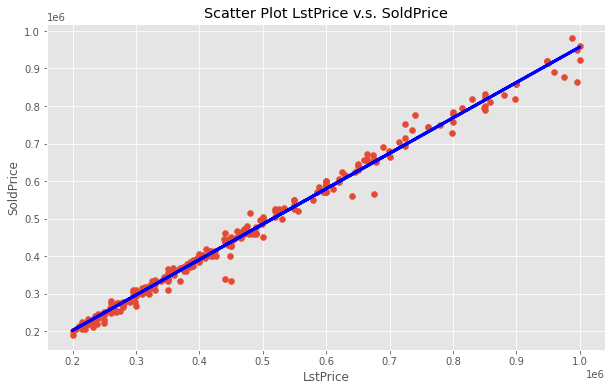

In [205]:
plt.scatter(h['LstPrice'], h['SoldPrice']);
plt.plot(h['LstPrice'],ad_TV_ols.predict(),'k',color='blue',linewidth=3)
plt.title("Scatter Plot LstPrice v.s. SoldPrice")
plt.xlabel('LstPrice');
plt.ylabel('SoldPrice');

In [210]:
ols = sm.ols(formula="SoldPrice ~ Prop_Type_num", data=h).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SoldPrice   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     47.67
Date:                Mon, 01 Mar 2021   Prob (F-statistic):           3.90e-11
Time:                        18:42:55   Log-Likelihood:                -3506.7
No. Observations:                 260   AIC:                             7017.
Df Residuals:                     258   BIC:                             7025.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       3.21e+05   2.17e+04     14.790      0.000    2.78e+05    3.64e+05
Prop_Type_num   1.73e+05   2.51e+04      6.904      0.000    1.24e+05    2.22e+05
==============================================================================
Omnibus:                       23.215   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.712
Skew:                           0.799   Prob(JB):                     9.60e-07
Kurtosis:                       2.922   Cond. No.                         3.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [211]:
ols = sm.ols(formula="SoldPrice ~ Prop_Type_num + TotSqf", data=h).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SoldPrice   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     106.8
Date:                Mon, 01 Mar 2021   Prob (F-statistic):           1.74e-34
Time:                        18:44:43   Log-Likelihood:                -3450.1
No. Observations:                 260   AIC:                             6906.
Df Residuals:                     257   BIC:                             6917.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.317e+05    1.9e+04     12.163      0.000    1.94e+05    2.69e+05
Prop_Type_num  8.248e+04   2.16e+04      3.819      0.000       4e+04    1.25e+05
TotSqf           76.4047      6.453     11.841      0.000      63.698      89.112
==============================================================================
Omnibus:                       50.902   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.893
Skew:                           1.128   Prob(JB):                     4.48e-18
Kurtosis:                       4.511   Cond. No.                     7.44e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

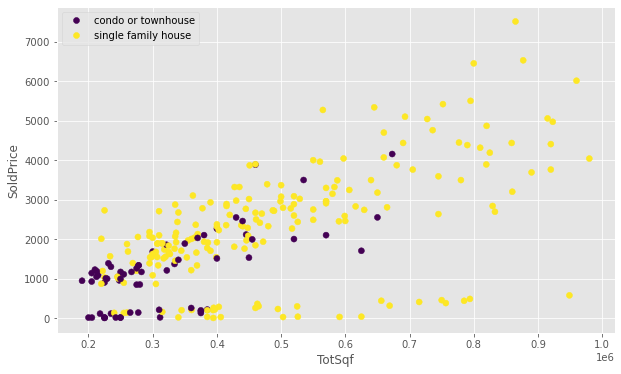

In [225]:
sca = plt.scatter(h['SoldPrice'], h['TotSqf'], c=h['Prop_Type_num']);
plt.xlabel('TotSqf');
plt.ylabel('SoldPrice');
plt.legend(handles=sca.legend_elements()[0], labels = ["condo or townhouse", "single family house"]);

##### explain for significance

The coefficient of `Prop_Type_num` decreases in size, also the `t` values for `Prop_Type_num` is smaller for two variable models than for one variable model. However, the `p` value is still significant for the variable. We should not leave out this attribute. The scatter plot also shows that the type of house and the total squares are correlated. The single family house is bigger in area, thus causing higher sales price.

### Task 2.5: Multilinear Regression 
Develop a multilinear regression model for house prices in this neighborhood. We could use this to come up with a list price for houses coming on the market, so do not include the list price in your model and, for now, ignore the categorical variable `Prop_Type`. Your model should be of the form:
$$
\text{Sold Price} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots +  \beta_n x_n, 
$$
where $x_i$ are predictive variables. Which variables are the best predictors for the Sold Price? 

Specific questions (feel free to extend the scope of your analysis):
1. Often the price per square foot for a house is advertised. Is this what the coefficient for `TotSqf` is measuring? Provide an interpretation for the coefficient for `TotSqf`.  
+ Estimate the value that each Garage space adds to a house. 
+ Does latitude or longitude have an impact on house price? Explain. 

In [242]:
[(i,c) for i,c in enumerate(h.columns)]

[(0, 'Acres'),
 (1, 'Deck'),
 (2, 'GaragCap'),
 (3, 'Latitude'),
 (4, 'Longitude'),
 (5, 'LstPrice'),
 (6, 'Patio'),
 (7, 'PkgSpacs'),
 (8, 'PropType'),
 (9, 'SoldPrice'),
 (10, 'Taxes'),
 (11, 'TotBed'),
 (12, 'TotBth'),
 (13, 'TotSqf'),
 (14, 'YearBlt'),
 (15, 'Prop_Type_num')]

In [243]:
ols = sm.ols(formula=f"SoldPrice ~  {'+'.join([c for i, c in enumerate(h.columns) if i not in [5,8,9]])}", data=h).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SoldPrice   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     105.4
Date:                Mon, 01 Mar 2021   Prob (F-statistic):           1.37e-92
Time:                        19:28:09   Log-Likelihood:                -3284.0
No. Observations:                 260   AIC:                             6596.
Df Residuals:                     246   BIC:                             6646.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.703e+08   8.76e+07     -1.944      0.053   -3.43e+08    2.23e+06
Acres          8.389e+04   7.13e+04      1.177      0.240   -5.65e+04    2.24e+05
Deck           1.186e+04   6222.200      1.906      0.058    -396.738    2.41e+04
GaragCap       2.456e+04   7041.051      3.488      0.001    1.07e+04    3.84e+04
Latitude       5.688e+05    1.3e+06      0.436      0.663      -2e+06    3.14e+06
Longitude     -1.336e+06   4.54e+05     -2.941      0.004   -2.23e+06   -4.41e+05
Patio         -2758.0800   2250.254     -1.226      0.221   -7190.301    1674.141
PkgSpacs       1734.0805   3184.950      0.544      0.587   -4539.171    8007.331
Taxes            57.5070      5.638     10.201      0.000      46.403      68.611
TotBed         1.353e+04   5907.661      2.290      0.023    1890.001    2.52e+04
TotBth         1.918e+04   7517.149      2.552      0.011    4376.062     3.4e+04
TotSqf            8.7243      4.608      1.893      0.059      -0.352      17.800
YearBlt          40.0851    232.713      0.172      0.863    -418.278     498.448
Prop_Type_num  4.656e+04   2.08e+04      2.242      0.026    5649.971    8.75e+04
==============================================================================
Omnibus:                       21.901   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.862
Skew:                           0.531   Prob(JB):                     4.44e-08
Kurtosis:                       4.413   Cond. No.                     8.40e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.4e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Your Interpretation:** 

Tax is the best predictor, since it has the largest `t` value, meaning that it is statistically most significant. The sales price and tax are highly dependent on each other. 

The price per square foot for a house as is advertised incorporates every features into account. It reflects them all, not just the area size. We just choose the area as a meaningful unit for doing the averages, we could also choose parking lot as a unit, like this house is $\$28000$ per parking lot, which is not very intuitive.

The coefficent for the total square feet variable means that for every unit increase of the square feet area, the sold price increases by $8.7243$ given other variables stay the same. However, this is not the most common case, for example we would be expecting to see taxes also increase together. Besides, `Acres` and `TotSqf` are very correlated, since they just express area in different units. The correlation also happens with other area related variables like the size of the garage etc. If we drop those features, we might have a more precise intepretation of the coefficient.

If we add one more garage space and keep all the other variables same, we are expected to have a $2.456e+04$ increase in sold price.

If we look at the magnitude of the coefficients of both longitude and latitude, they all have large coefficent. However, longitude is statistically significant at $5\%$ significance level, while latitude is not. So we can only be confident in saying that longitude has an impact on the sold price. Perhaps the samples are drawn from an area where the geo-economical diversity is much greater in longitude than latitude.

### Task 2.6: Deliver a robust model, where you have included an analysis of all variables etc.

If we wanted to start a 'house flipping' company, we'd have to be able to do a better job of predicting the sold price than the list price does. How does your model compare?

Based on the exploration in the tasks above, build and deliver a robust model for predicting the sold price. As a minimal and required step here, you need to use cross-validation and regularization and demonstrate their effect on the model.

Once you have such a model, you are free to explore any other models you want (also beyond the scope of the course), however that is not necessary. You are not going to be judged on the performance of your model, but on the methodology you followed to build your model and the interpretation of the results.

In [756]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [757]:
h = pd.read_csv('housespp.csv',index_col=0) #load data
h = h.reset_index()
h = h.drop(columns=['ListNo'])

In [758]:
h.dtypes

Access        object
Acres        float64
AirType       object
Amenities     object
DaysOnMkt    float64
Deck           int64
GaragCap       int64
Heat          object
Latitude      object
Longitude     object
LstPrice       int64
Patio          int64
PkgSpacs       int64
PropType      object
Roof          object
SoldPrice      int64
Taxes          int64
TotBed       float64
TotBth       float64
TotSqf        object
YearBlt        int64
dtype: object

In [759]:
# transform categorical var to dummy var 
def to_dummy(h, col_name):
    col = h[col_name].fillna('Unknown')
    m = set()
    for l in col:
        if l:
            for k in l.split(';'):
                m.add(k.strip())
    _dummies = pd.DataFrame(np.zeros((col.shape[0], len(m))), columns=m, dtype=int)
    for i, l in enumerate(col):
        for k in l.split(';'):
            k = k.strip()
            _dummies.loc[i, k] = 1
    h = h.drop(columns=[col_name])
    if 'See Remarks' in m:
        _dummies = _dummies.drop(columns=['See Remarks'])
    h = h.join(_dummies.add_prefix(col_name))
    return h

# we do a similar processing as in preprocessing section but includes all columns
def preprocess2(h):
    def processCoordinate(x):
        try:
            x1,x2,x3 = [float(e) for e in x.split('.')]
            return x1 + (x2*1000 + x3)/1000000
        except:
            return np.NaN

#     h = h[(h['LstPrice'] >= 200000) & (h['LstPrice'] <= 1000000)]
    h['TotSqf'] = h['TotSqf'].str.replace(',', '').astype(int)
#     dummies = pd.get_dummies(h['PropType'])
#     h['Prop_Type_num'] = (dummies['Single Family'] == 1).astype(int)        
    h['Longitude'] = h['Longitude'].apply(processCoordinate)
    h['Latitude'] = h['Latitude'].apply(processCoordinate)
#     h = h.dropna()
    return h
    

In [760]:
for colname in ['Access', 'AirType', 'Amenities', 'Heat', 'PropType','Roof']:
    h = to_dummy(h, colname)
h = preprocess2(h)

In [761]:
h[h.isnull().any(axis=1)]

,Acres,DaysOnMkt,Deck,GaragCap,Latitude,Longitude,LstPrice,Patio,PkgSpacs,SoldPrice,...,RoofWood Shake Shingles,RoofPvc,RoofFlat,RoofRolled-Silver,RoofMetal,RoofUnknown,RoofMembrane,RoofTile,RoofAluminum,RoofBitumen
6,0.14,NaN,1,2,40.783889,-110.127806,600000,1,2,570000,...,0,0,0,0,0,0,0,0,0,1
15,0.35,NaN,1,3,40.781810,-110.150968,1080000,1,0,1050000,...,0,0,0,0,0,0,0,0,0,0
17,0.09,NaN,0,1,40.771684,-110.133600,225000,0,0,225000,...,0,0,0,0,0,0,0,0,0,0
39,0.29,NaN,1,3,40.781875,-110.130546,640000,1,3,560500,...,0,0,0,0,0,0,0,0,0,0
91,0.00,NaN,1,0,40.783421,-110.101947,127500,0,0,126500,...,0,0,0,0,0,0,0,0,0,0
95,0.12,NaN,1,2,40.777644,-110.133139,524900,1,0,519900,...,0,0,0,0,0,0,0,0,0,0
96,0.14,NaN,0,1,40.780497,-110.125201,299000,1,0,295000,...,0,0,0,0,0,0,0,0,0,0
98,0.00,NaN,0,0,40.783421,-110.101947,142000,0,0,142000,...,0,0,0,0,0,0,0,0,0,0
99,0.00,NaN,1,0,40.783421,-110.101947,142000,0,1,137750,...,0,0,0,0,0,0,0,0,0,0
100,0.00,NaN,0,0,40.783421,-110.101947,136500,0,0,134000,...,0,0,0,0,0,0,0,0,0,0


In [762]:
h = h.dropna()

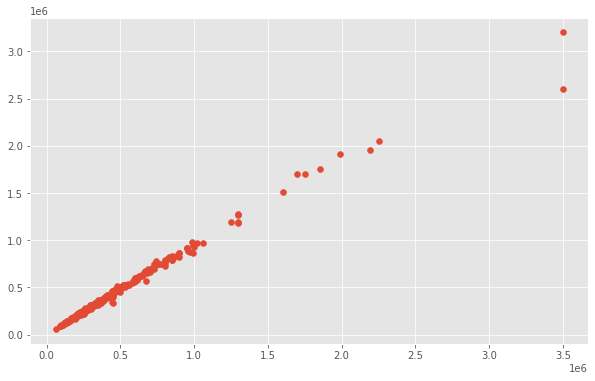

In [764]:
plt.scatter(h['LstPrice'], h['SoldPrice']);

In [765]:
# drop the two outliners
h = h.drop(h[h['LstPrice'] > 3e6].index)

In [766]:
#after transforming to dummy columns, we have increased the dimension to 85
h.shape

(325, 85)

If we want to beat the housing agent, we must know what the performance of a single variable(i.e., LstPrice) linear regression is, we did it earlier with statsmodel but without train test split, here we do it again using sklearn and with test size $0.1$ of total data size.

In [828]:
X = h.drop(columns=['SoldPrice']).to_numpy()
Y = h['SoldPrice'].to_numpy()
X_non_test, X_test, Y_non_test, Y_test = train_test_split(X,Y, test_size = 0.1, shuffle=True, random_state =42)
columns = h.drop(columns=['SoldPrice']).columns

In [833]:
name_to_idx = {k: i for i, k in enumerate(columns)}

In [798]:
def get_avg_result(clf, X,Y, n=10, debug=True):
    train_scores = []
    test_scores = []
    for train_idx, test_idx in KFold(n_splits=n, shuffle=True, random_state=42).split(X):
        clf.fit(X[train_idx], Y[train_idx])
        train_score = clf.score(X[train_idx], Y[train_idx])
        test_score = clf.score(X[test_idx], Y[test_idx])
        train_scores.append(train_score)
        test_scores.append(test_score)
    avg_train = np.average(train_scores)
    avg_test = np.average(test_scores)
    if debug:
        print(pd.DataFrame([[avg_train, np.std(train_score)], [avg_test, np.std(test_score)]], columns=['avg', 'std'],index=['train','test']))
    return avg_test
#         print(f"model with LstPrice only\nAverage train score {avg_train}\nAverage test score: {avg_test}")
        


In [848]:
lr = LinearRegression()
lr.fit(X_non_test[:, name_to_idx['LstPrice']].reshape(-1,1), Y_non_test)
print(f"test score(r2) for single variable model: {lr.score(X_test[:, name_to_idx['LstPrice']].reshape(-1,1), Y_test)}")

test score(r2) for single variable model: 0.9968944672420894


In [869]:
def plot_residual_hist(lr, x, y):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
    yhat = lr.predict(x)
    res = yhat - y
    sn.regplot(x, res, lowess=True, 
        ax=ax1, line_kws={'color':'b', 'lw':1},
        scatter_kws={'facecolors':'None', 'edgecolors':'k', 'alpha':0.5})
    ax1.hlines(0,xmin=ax1.xaxis.get_data_interval()[0],
               xmax=ax1.xaxis.get_data_interval()[1], linestyles='dotted')
    ax1.set_xlabel('Fitted values')
    ax1.set_ylabel('Residuals')
    ax1.set_title('Residual Plot for Linear Fit')
    sn.histplot(res, ax=ax2)

/Users/septem/opt/miniconda3/envs/da/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


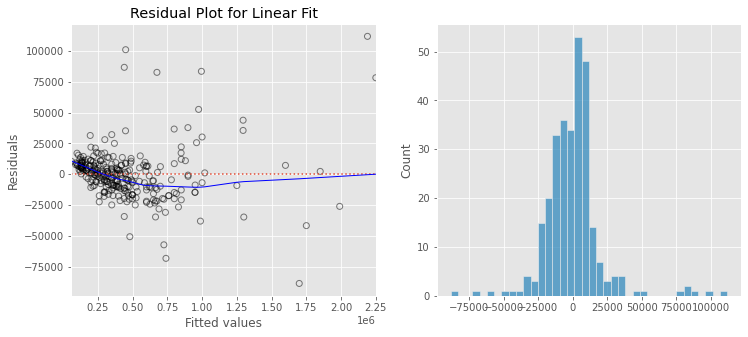

In [871]:
plot_residual_hist(lr, X_non_test[:, name_to_idx['LstPrice']].reshape(-1,1), Y_non_test);

Residual plot and histogram plot shows the residual is approximately normally distributed, which means the single variable model is a good fit.

The coming model needs to score higher than $99.69\%$, which is our one variable model score, in order to do house flipping.

We first try regularization technique.

In [873]:
alphas = [10e-3, 10e-2, 10e-1, 1, 10, 100, 1000]
l_cv = LassoCV(alphas= alphas, normalize=True, cv = 10)
r_cv = RidgeCV(alphas= alphas, normalize=True, cv = 10)
l_cv.fit(X_non_test, Y_non_test)
r_cv.fit(X_non_test, Y_non_test)
print(l_cv.score(X_test, Y_test), r_cv.score(X_test, Y_test))

0.9968303197319636 0.9900126316235948


In [874]:
l_cv.alpha_

100.0

We saw that lasso with alpha set to $100$ gives us the best test score 0.9968303197319636, which is higher than 0.9968944672420894 from our one variable model. 

Of course the margin is small, but any margin would be small considering we have little space for improvement since we already have high score with single variable model and we still have error term that is present in every model that is not controlable. 

In [889]:
coef = pd.Series(l_cv.coef_, index = columns)

In [891]:
coef[abs(coef) > 10e-6] #choose coef with abs value greater than 10e-6

Acres                          10258.559675
DaysOnMkt                        -23.545818
GaragCap                         635.947264
LstPrice                           0.924248
PkgSpacs                        -621.909262
AirTypeEvap. Cooler: Window    -2773.279796
AirTypeWindow                  -3875.445580
AirTypeUnknown                 -6446.077070
AmenitiesHome Warranty           204.397926
HeatElectric: Radiant          -9227.533713
PropTypeCondo                  -7971.505424
RoofTile                       -1286.696737
dtype: float64

Plus, the lasso also gives us sparse and thus more intepretable result. We see the coefficients all make sense. The bigger the house, the higher the sold price (Acres). The more the house is in the market, which indicates the house is harder to sell, the less it sales (DaysOnMkt). The more garage space you have, then more it sells(GaragCap). The higher the list price, the higher it will sell. AirType also influences the house price(AirType*), the old stype air system will lower the sold price. Having warranty also makes house more popular. Lastly house type condo also makes house less popular, as people don't want to live with other people too close by...

------------------extra---------------------

We could also try other methods to determine the features instead of using the punishment.

We use forward selection to determine the features.

In [851]:
#forward selection, changed a few place, namely, the best feature is determined by cross validation, no longer by single trial
def forward_selection(cols, x_non_test, y_non_test):
    all_predictors = cols

    predictors = [([], 0)]

    regression_model = LinearRegression(fit_intercept=True)

    R_sq_fwd = []

    for k in range(1, len(all_predictors)):
        best_k_minus_1 = predictors[-1][0]
        new_predictors = list(set(all_predictors) - set(best_k_minus_1))
        validation_R_sqs = []

        for predictor in new_predictors:

            k_predictors = best_k_minus_1 + [predictor]
            
            avg = get_avg_result(regression_model, x_non_test[:, k_predictors], y_non_test, debug=False)            
            
            validation_R_sqs.append(avg)

        best_k = best_k_minus_1 + [new_predictors[np.argmax(validation_R_sqs)]]
        R_sq_fwd.append(np.max(validation_R_sqs))
        predictors.append((best_k, np.max(validation_R_sqs)))



    avg = get_avg_result(regression_model, x_non_test, y_non_test, debug=False)

    predictors.append((all_predictors, avg))
    return predictors


In [ ]:
predictors = forward_selection(np.arange(len(columns)), X_non_test, Y_non_test)

In [805]:
sorted_predictors = sorted(predictors, key=lambda x: x[1], reverse=True)

In [852]:
for k in sorted_predictors[:5]: # the top 5 feature combinations determined by validation together with their average validation score
    print(k[0], k[1])

[6, 1, 67, 28, 22, 48, 8, 31, 75, 37, 16, 24, 29, 27, 83] 0.9951976255110686
[6, 1, 67, 28, 22, 48, 8, 31, 75, 37, 16, 24, 29, 27, 83, 30] 0.9951976255110686
[6, 1, 67, 28, 22, 48, 8, 31, 75, 37, 16, 24, 29, 27, 83, 30, 32] 0.9951976255110686
[6, 1, 67, 28, 22, 48, 8, 31, 75, 37, 16, 24, 29, 27, 83, 30, 32, 64] 0.9951976255110686
[6, 1, 67, 28, 22, 48, 8, 31, 75, 37, 16, 24, 29, 27] 0.99519672827464


In [809]:
for col in sorted_predictors[:5]: # print the top 5 test score
    c = col[0]
    lr = LinearRegression()
    lr.fit(X_non_test[:, c], Y_non_test)
    print(lr.score(X_test[:,c], Y_test))

0.9957381278585655
0.9957381278585655
0.9957381278585655
0.9957381278585655
0.9957333861037208


We saw that by forward selection method the lr score is $0.9957381278585655$ on the selected features, which is lower than lasso. The one variable model does not make to the top 5(since we use validation set to determine the rank), which gives us the second best test score in our experiment.